# Example - Background estimation

*This notebook is part of smFRET burst analysis software [FRETBursts](http://opensmfs.github.io/FRETBursts/).*

> In this notebook, we show different ways of computing, plotting and exporting background data.
> For a complete tutorial on burst analysis see 
> [FRETBursts - us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).

In [1]:
import pandas as pd
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook(apionly=True)
print('seaborn version: ', sns.__version__)

seaborn version:  0.8.0


In [3]:
# Tweak here matplotlib style
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

# Retrieve the data

In [4]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'
download_file(url, save_dir='./data')
full_fname = "./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"

d = loader.photon_hdf5(full_fname)
loader.alex_apply_period(d)

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


# Total photons (after ALEX selection):     2,259,522
#  D  photons in D+A excitation periods:      721,537
#  A  photons in D+A excitation periods:    1,537,985
# D+A photons in  D  excitation period:     1,434,842
# D+A photons in  A  excitation period:       824,680



# Background estimation

The first step of the analysis is estimating the background. 
The assumption is that the background is a Poisson process and therefore 
the corresponding inter photon delays are exponentially distributed. Since the 
background can change during the measurement, a new estimation is 
computed every `time_s` seconds (this time is called the *background period*).

The inter-photon delay distribution contains both single-molecule signal and background. 
The single-molecule signal produces a inter-photon delays at short time scales, while
the background produces an exponential tail extenting to longer timescales.
Hence, we need a threshold to discriminate between the exponential tail and the single-molecule peak.

FRETBursts provides several ways to specify the minimum threshold 
and different functions to fit the exponential tail.

The reference documentation is the following:

- Documentation for [`Data.calc_bg()`](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.calc_bg)
- Documentation for [`background` (e.g. `bg`) module](http://fretbursts.readthedocs.org/en/latest/background.html)
- Documentation for [`exp_fitting` module](http://fretbursts.readthedocs.org/en/latest/background.html#module-fretbursts.fit.exp_fitting).

## Single threshold

Let start with a standard Maximum Likelihood (ML) 
background fit with a minimum tail threshold of 500 μs:

In [5]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=500)

 - Calculating BG rates ... 

[DONE]


We can look at how the fit looks with:

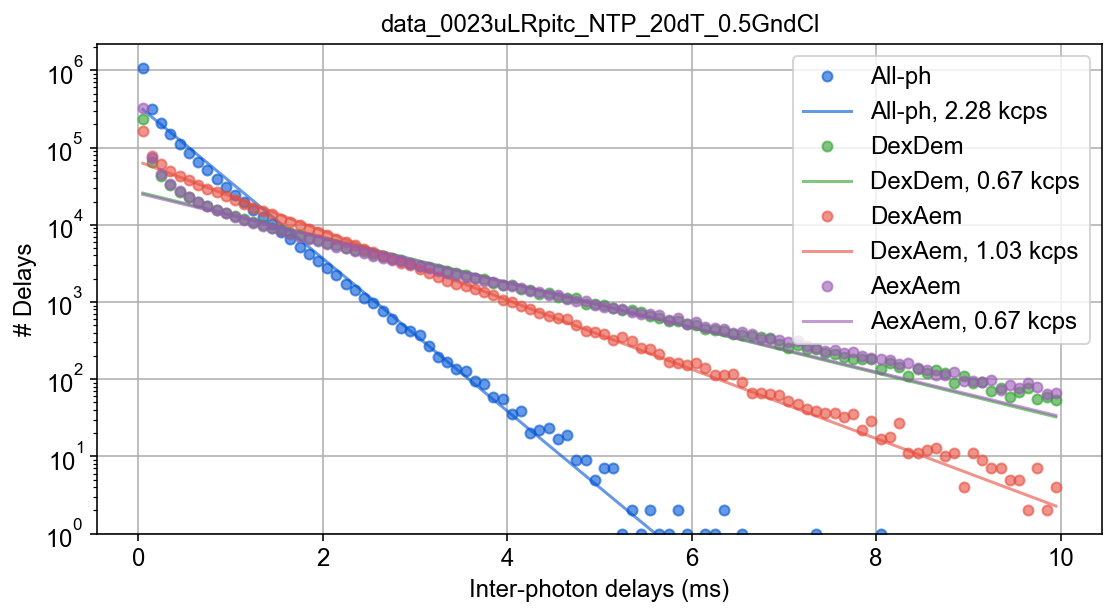

In [6]:
dplot(d, hist_bg, show_fit=True);

Note that the fits are not very good. This is understandable because 
we used a single threshold for all the photon streams, each one
having a quite different background.

## Multiple thresholds

To improve the fit, we can try specifying a threshold for each channel.
This method is bit ad-hoc but it may work well when the 
thresholds are properly choosen.

In [7]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=(800, 4000, 1500, 1000, 3000))

 - Calculating BG rates ... 

[DONE]


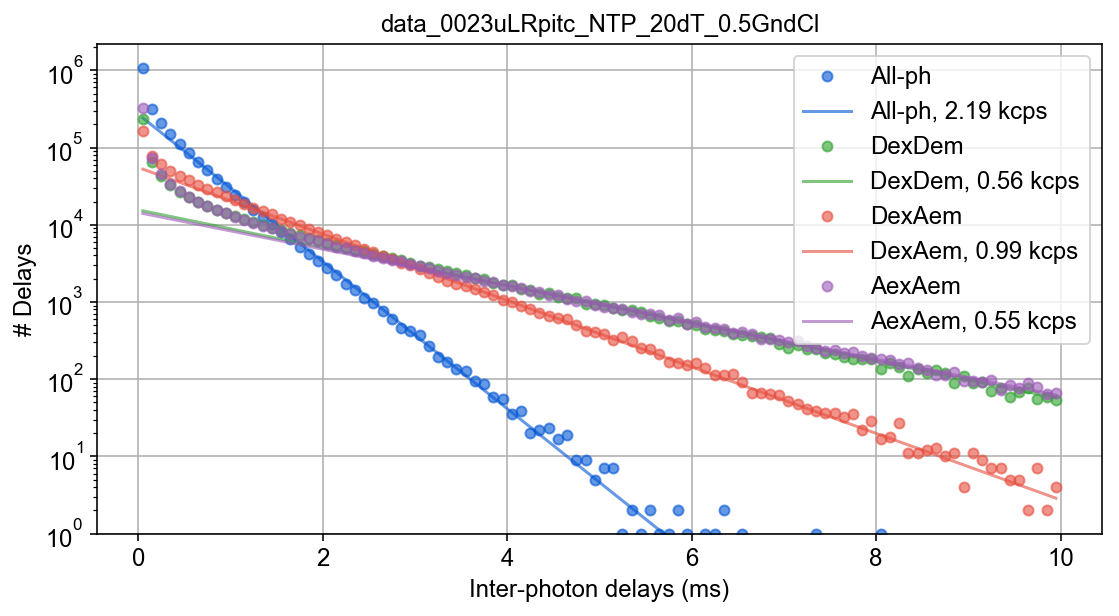

In [8]:
dplot(d, hist_bg, show_fit=True);

For ALEX measurements, the tuple passed to
`tail_min_us` in order to define the thresholds needs to contain  
5 values corresponding the 5 distinct photon streams 
(the all-photon stream plus the 4 base alternation streams).
The order of these 5 values need to match the order of photon streams in
the `Data.ph_streams` attribute:

In [9]:
d.ph_streams

[Ph_sel(Dex='DAem', Aex='DAem'),
 Ph_sel(Dex='Dem', Aex=None),
 Ph_sel(Dex='Aem', Aex=None),
 Ph_sel(Dex=None, Aex='Dem'),
 Ph_sel(Dex=None, Aex='Aem')]

## Automatic threshold

Finally, is possible to let FRETBursts infer the threshold automatically (recommended) with:

In [10]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


Which results in the following fit plot:

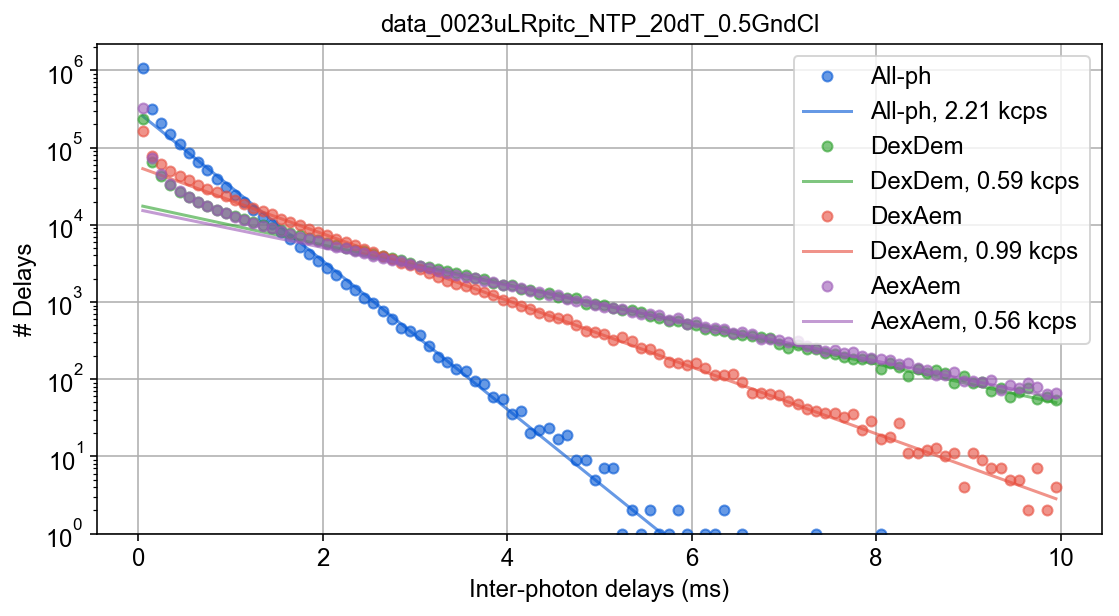

In [11]:
dplot(d, hist_bg, show_fit=True);

Under the hood, this method estimates the threshold 
according to this formula:

    threshold_auto = F_bg / coarse_background_rate

where `F_bg` is an input argument (by default 1.7)
and `coarse_background_rate` is an initial background estimation
performed with a fixed threshold. This method is concemptually an
iterative method to compute the threshold that is stopped
after the second iteration (this is usually more than enough for
accurate estimates).

This latter method is the recommended,
since it works well and without user intervention in 
a wide range of experimental conditions.

## Background timetrace

It is a good practice to monitor background rates as a function of time.
Here, we compute background in adjacent 30s windows (called *background periods*)
and plot the estimated rates as a function of time.

In [12]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


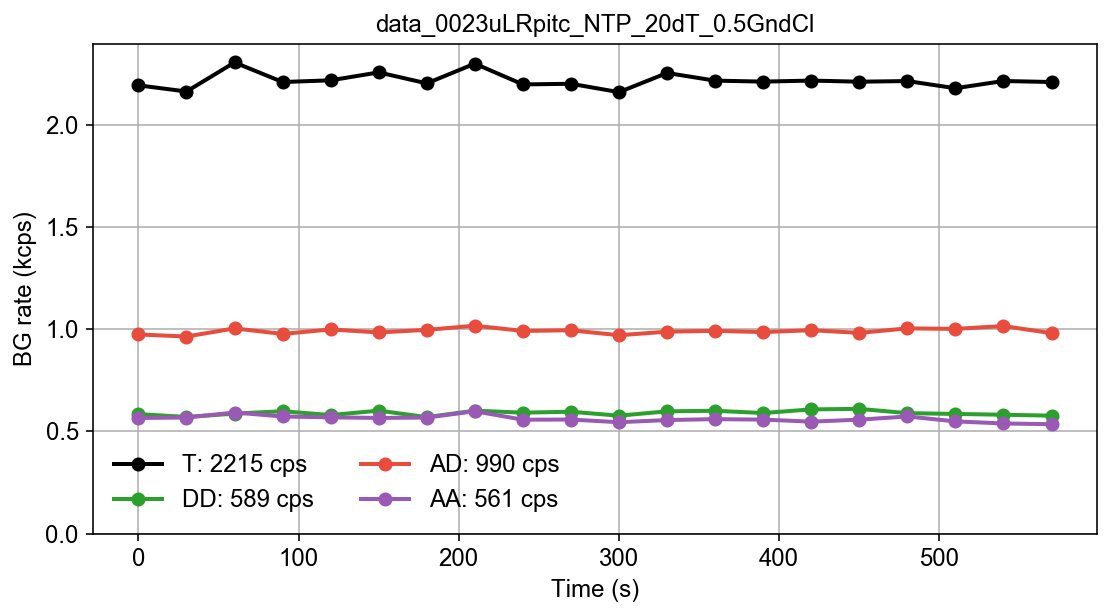

In [13]:
dplot(d, timetrace_bg);

## Getting the background rates

The background rates are stored in `Data()` attribute
`bg`, a dict with photon streams (`Ph_sel` objects) as key. 
Each item in the dict contains a list of fitted background rates 
for each channel and period.

In [14]:
d.bg

{Ph_sel(Dex='DAem', Aex='DAem'): [array([ 2192.33771456,  2162.14083635,  2304.31199333,  2208.57734993,
          2216.88852285,  2255.68759074,  2202.02910176,  2298.45997825,
          2196.7975027 ,  2199.98590374,  2159.05120194,  2252.82753492,
          2215.34278931,  2210.60163812,  2215.6184806 ,  2210.1510978 ,
          2213.32385234,  2178.18199206,  2213.60242855,  2208.64479515])],
 Ph_sel(Dex='Dem', Aex=None): [array([ 584.18970691,  570.58641253,  586.80564353,  598.45561342,
          579.68811571,  601.34029113,  569.74563784,  601.248969  ,
          591.47186394,  596.06342699,  576.64661876,  598.0513001 ,
          600.65952237,  589.70963389,  607.49394193,  610.00901454,
          589.13559128,  585.2150928 ,  581.32356205,  576.791585  ])],
 Ph_sel(Dex='Aem', Aex=None): [array([  973.96356856,   963.80151895,  1003.656506  ,   976.56430321,
           998.56747257,   983.73415654,   996.47590969,  1016.73812567,
           991.14920045,   994.47939727,   970.1

We can also get the average background for each channel:

In [15]:
d.bg_mean

{Ph_sel(Dex='DAem', Aex='DAem'): [2215.7281152497922],
 Ph_sel(Dex='Dem', Aex=None): [589.73157718553762],
 Ph_sel(Dex='Aem', Aex=None): [990.55292377373189],
 Ph_sel(Dex=None, Aex='Dem'): [74.771243227050803],
 Ph_sel(Dex=None, Aex='Aem'): [561.52361523921024]}

In [16]:
bg_data = pd.DataFrame({str(k): v[0] for k, v in d.bg.items()})
bg_data

,AexAem,AexDem,DexAem,DexDem,all
0,565.412755,81.253925,973.963569,584.189707,2192.337715
1,567.698563,77.349352,963.801519,570.586413,2162.140836
2,592.026803,70.857414,1003.656506,586.805644,2304.311993
3,572.781262,73.751335,976.564303,598.455613,2208.577350
4,568.498588,76.242228,998.567473,579.688116,2216.888523
...,...,...,...,...,...
15,557.252290,77.006959,981.689397,610.009015,2210.151098
16,572.928892,74.038019,1003.743056,589.135591,2213.323852
17,548.837144,72.810020,1001.229063,585.215093,2178.181992
18,538.595247,73.926098,1015.024631,581.323562,2213.602429


# Burst analysis

After background estimation, you are ready to perform burts search.

If you want more details see
[Burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb#Burst-analysis).

---
**Executed:** Tue Nov 21 22:58:18 2017

**Duration:** 8 seconds.

**Autogenerated from:** [Example - Background estimation.ipynb](out/Example - Background estimation.ipynb)